In [141]:
# Scipy imports
import scipy.io as sio
from scipy.fft import fft, fftfreq

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Selecting Patient Dataset

I've downloaded the following patient data and I have also its quality:
- `S1.mat` $\rightarrow$ good patient data
- `S3.mat` $\rightarrow$ good patient data
- `S31.mat` $\rightarrow$ good patient data
- `S32.mat` $\rightarrow$ good patient data
- `S19.mat` $\rightarrow$ medium patient data
- `S29.mat` $\rightarrow$ bad patient data

In [142]:
subject = 1
eeg_raw_data = sio.loadmat(f'./data/S{subject}.mat')['data']

show_feature_matrix = False

print(eeg_raw_data.shape)

(64, 1500, 40, 6)


## Filtering with CAR

In [143]:
number_of_trials = eeg_raw_data.shape[3]
number_of_frequencies = eeg_raw_data.shape[2]

# Applying CAR filter to all trials and frequencies
eeg_filtered_data = np.zeros(eeg_raw_data.shape)
for trial in range(number_of_trials):
    for freq in range(number_of_frequencies):
        trial_frequency_data = np.array(eeg_raw_data[:, :, freq, trial])
        car_mean = np.mean(trial_frequency_data, axis=0)
        eeg_filtered_data[:, :, freq, trial] = trial_frequency_data - car_mean

## CAR Filter Applied to Patient Dataset

In [144]:
trial = 0
freq = 0 # 8 Hz

useful_data = np.array(eeg_raw_data[:, 125:1375, freq, trial])

electrodes_indexes = {"Oz": 61, "Cz": 27, "Fcz": 18}

samples = 1250
spacing = 4
time_range = np.linspace(0, samples * spacing, samples)
freq_range = fftfreq(samples, spacing)[: samples // 2] * 1000

### Applying CAR filter

In [145]:
# applying CAR filter
oz_values = useful_data[electrodes_indexes['Oz'], :]
cz_values = useful_data[electrodes_indexes['Cz'], :]
fcz_values = useful_data[electrodes_indexes['Fcz'], :]

car_mean = np.mean(useful_data, axis=0)

electrodes_df = pd.DataFrame({
  'Oz': oz_values - car_mean,
  'Cz': cz_values - car_mean,
  'FCz': fcz_values - car_mean,
  'Time (ms)': np.linspace(0, samples * spacing, samples)
})

electrodes_df.head()


,Oz,Cz,FCz,Time (ms)
0,1.846361,-0.424398,0.210495,0.000000
1,-0.734012,-1.069103,0.518279,4.003203
2,-0.464213,-0.408909,0.259346,8.006405
3,-2.806916,0.434569,3.256448,12.009608
4,-3.756761,1.083374,3.842090,16.012810


In [146]:
fft_electrodes_df = pd.DataFrame({
  'Oz': 2/samples * np.abs(fft(np.array(electrodes_df['Oz']))[0:samples//2]),
  'Cz': 2/samples * np.abs(fft(np.array(electrodes_df['Cz']))[0:samples//2]),
  'FCz': 2/samples * np.abs(fft(np.array(electrodes_df['FCz']))[0:samples//2]),
  'Frequency (Hz)': freq_range
})

print(fft_electrodes_df.columns.values)
fft_electrodes_df.head()

['Oz' 'Cz' 'FCz' 'Frequency (Hz)']


,Oz,Cz,FCz,Frequency (Hz)
0,0.316406,0.517054,1.730666,0.0
1,1.826312,1.591388,0.611202,0.2
2,2.371483,0.799178,0.989022,0.4
3,1.708234,1.612493,1.293411,0.6
4,1.925787,0.782415,1.009690,0.8


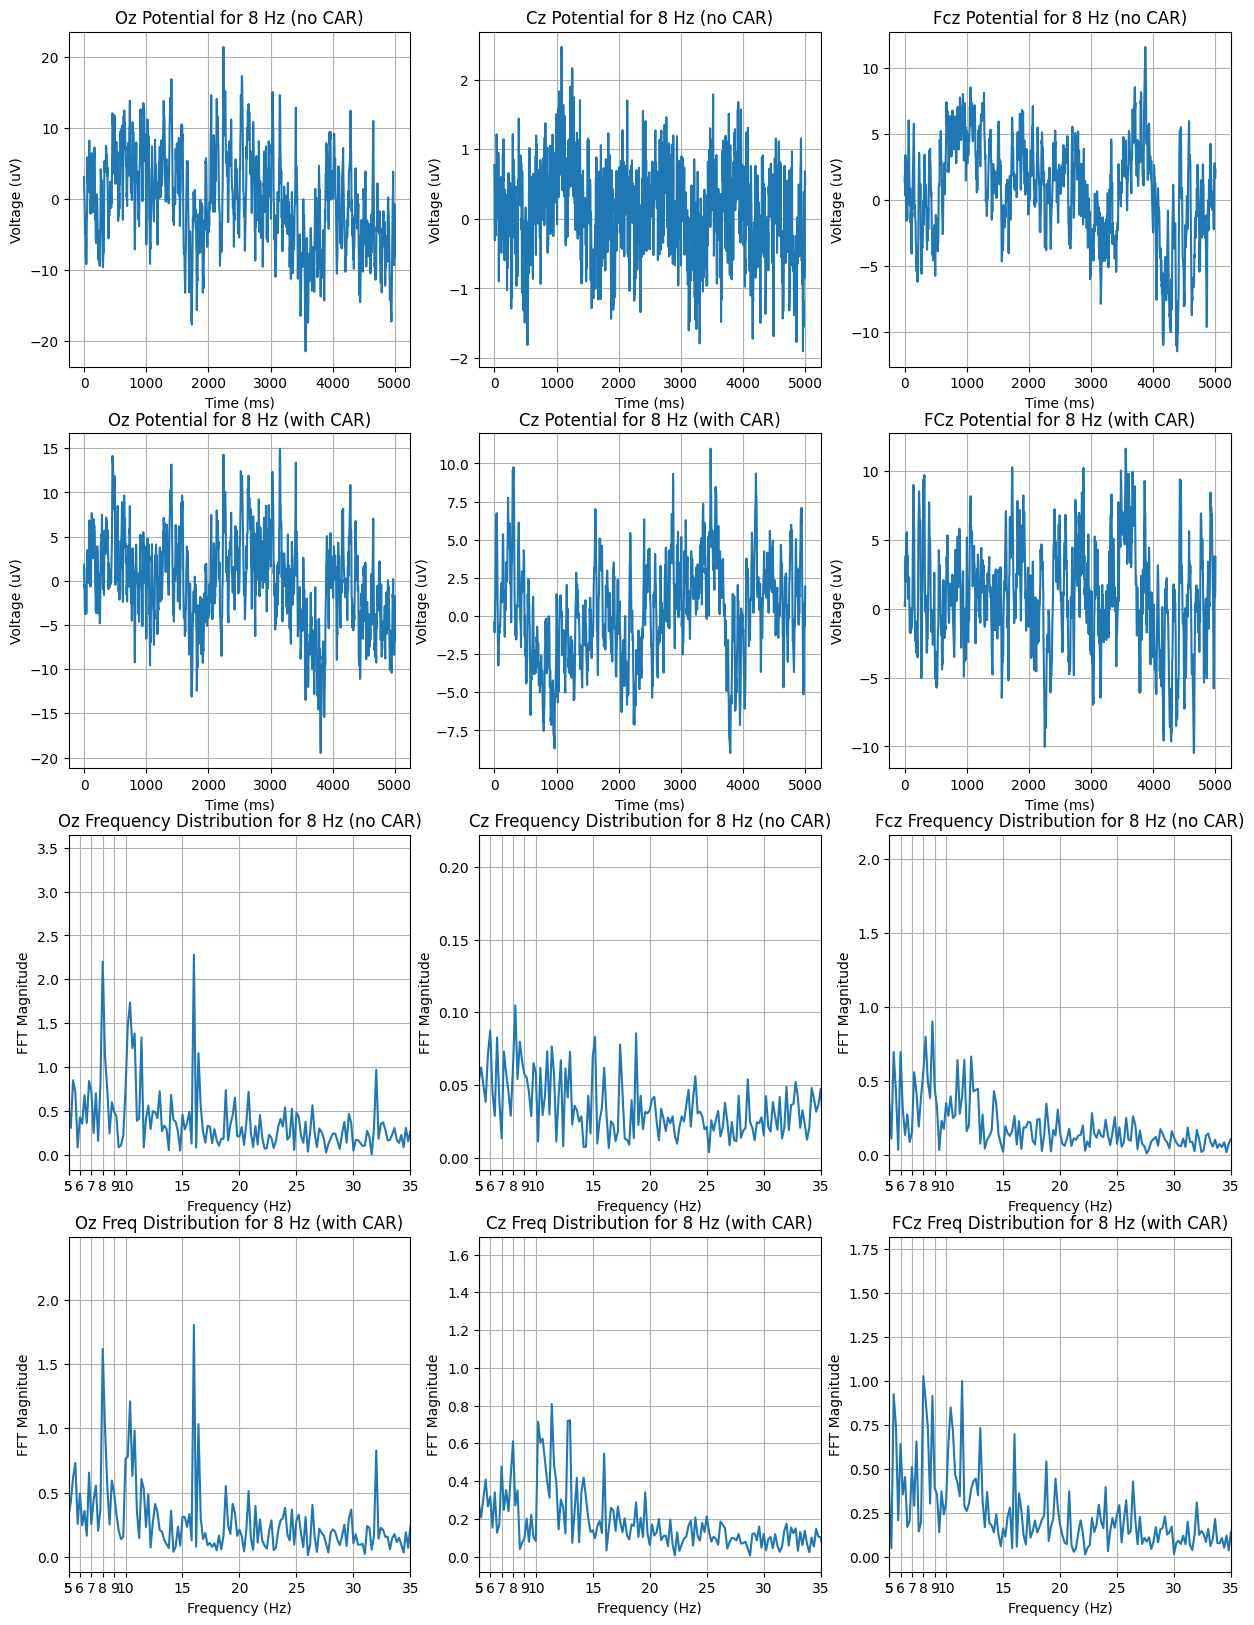

In [147]:
fig, axes = plt.subplots(4, len(electrodes_indexes.values()), figsize=(15, 20))

for i, electrode in enumerate(electrodes_indexes):
    electrode_index = electrodes_indexes[electrode]
    electrode_data = useful_data[electrode_index, :]
    electrode_fft = 2 / samples * np.abs(fft(electrode_data)[0 : samples // 2])

    axes[0, i].set_title(f"{electrode} Potential for 8 Hz (no CAR)")
    axes[0, i].plot(time_range, electrode_data)
    axes[0, i].set_xlabel("Time (ms)")
    axes[0, i].set_ylabel("Voltage (uV)")
    axes[0, i].grid()

    axes[2, i].set_title(f"{electrode} Frequency Distribution for 8 Hz (no CAR)")
    axes[2, i].plot(freq_range, electrode_fft)
    axes[2, i].set_xticks(np.hstack((np.arange(0, 100, 5), np.arange(5, 10, 1))))
    axes[2, i].set_xlim(5, 35)
    axes[2, i].set_xlabel("Frequency (Hz)")
    axes[2, i].set_ylabel("FFT Magnitude")
    axes[2, i].grid()

for i, column in enumerate(electrodes_df.columns.values):
  if column == 'Time (ms)':
    continue
  axes[1, i].set_title(f'{column} Potential for 8 Hz (with CAR)')
  axes[1, i].plot(electrodes_df['Time (ms)'], electrodes_df[column])
  axes[1, i].set_xlabel('Time (ms)')
  axes[1, i].set_ylabel('Voltage (uV)')
  axes[1, i].grid()
  
for i, column in enumerate(fft_electrodes_df.columns.values):
  if column == 'Frequency (Hz)':
    continue
  axes[3, i].set_title(f'{column} Freq Distribution for 8 Hz (with CAR)')
  axes[3, i].plot(fft_electrodes_df['Frequency (Hz)'], fft_electrodes_df[column])
  axes[3, i].set_xticks(np.hstack((np.arange(0, 100, 5), np.arange(5, 10, 1))))
  axes[3, i].set_xlim(5, 35)
  axes[3, i].set_xlabel('Frequency (Hz)')
  axes[3, i].set_ylabel('FFT Magnitude')
  axes[3, i].grid()


# Feature Extraction

- Selected frequencies for feature extraction phase: 8 Hz (0), 10 Hz (2), 12 Hz (4) and 14 Hz (6)
- Each frequency will have 5 windows of data (1s wide) to each of the 6 trials

## Creating Label Vectors

In [148]:
windows = 5
trials = 6

four_frequencies = {
    8: 0, 10: 2, 12: 4, 15: 7,
}

seven_frequencies = {
    8: 0, 9: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6,
}

forty_frequencies = {
    8: 0, 9: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7,
    8.2: 8, 9.2: 9, 10.2: 10, 11.2: 11, 12.2: 12, 13.2: 13, 14.2: 14, 15.2: 15,
    8.4: 16, 9.4: 17, 10.4: 18, 11.4: 19, 12.4: 20, 13.4: 21, 14.4: 22, 15.4: 23,
    8.6: 24, 9.6: 25, 10.6: 26, 11.6: 27, 12.6: 28, 13.6: 29, 14.6: 30, 15.6: 31,
    8.8: 32, 9.8: 33, 10.8: 34, 11.8: 35, 12.8: 36, 13.8: 37, 14.8: 38, 15.8: 39,
}

selected_frequencies = four_frequencies

print(f"Selected frequencies: {selected_frequencies}")

Selected frequencies: {8: 0, 10: 2, 12: 4, 15: 7}


In [149]:
Y_1 = np.zeros(windows * trials * len(selected_frequencies), int)

for i, frequency in enumerate(selected_frequencies.keys()):
    for j in range(trials):
        for k in range(windows):
            Y_1[i * trials * windows + j * windows + k] += i

# print("Y_1: ", Y_1)
print(Y_1.shape)

(120,)


(120, 4)


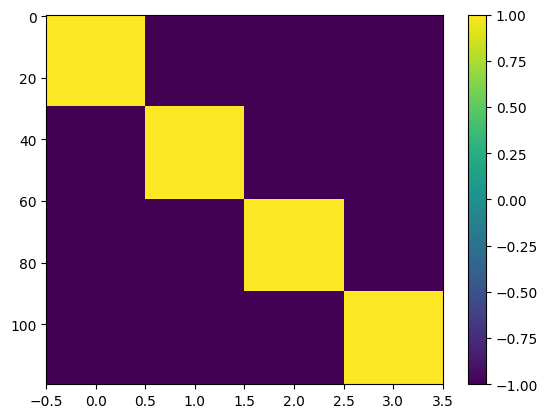

In [150]:
Y_2 = np.ones((windows * trials * len(selected_frequencies), len(selected_frequencies)), int)

for i in range(windows * trials * len(selected_frequencies)):
    for j in range(len(selected_frequencies)):
        if int(i / (windows * trials)) != j:
            Y_2[i, j] *= -1

# print("\nY_2: ", Y_2)
print(Y_2.shape)
plt.imshow(Y_2, aspect='auto')
plt.colorbar()
plt.show()

## Creating Feature Matrix

In [151]:
selected_channels = {
    # "Pz": 47,
    # "PO5": 53,
    # "PO3": 54,
    "POz": 55,
    # "PO4": 56,
    # "PO6": 57,
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}
selected_eeg_data = eeg_filtered_data
number_of_channels = len(selected_channels)
selected_channel_indices = list(selected_channels.values())

windowed_data = np.split(
    selected_eeg_data[selected_channel_indices, 125:1375, :, :], indices_or_sections=windows, axis=1
)
print('Windowed data:', np.array(windowed_data).shape)

Windowed data: (5, 4, 250, 40, 6)


In [152]:
select_first_harmonic = True
number_of_frequencies = len(selected_frequencies) * (2 if select_first_harmonic else 1)

# create a first line for vstack
# each column is a channel for a frequency and each row is a trial for a window
# k is the window, j is the trial, i is the frequency, l is the channel

X = np.array(
    [
        np.zeros(
            number_of_channels
            * number_of_frequencies
        )
    ]
)

frequency_values_to_select = list(selected_frequencies.keys())
if select_first_harmonic: # append the first harmonic
    frequency_values_to_select = np.hstack(
        (frequency_values_to_select, np.array(frequency_values_to_select) * 2)
    )

for i, frequency in enumerate(selected_frequencies.values()):
    for j in range(trials):
        for k in range(windows):
            temp = np.array([])
            for l in range(number_of_channels):
                channel_data = windowed_data[k][l, :, frequency, j]
                channel_fft = np.abs(fft(channel_data))
                # temp = np.hstack((temp, channel_fft[list(selected_frequencies.keys())]))
                temp = np.hstack((temp, channel_fft[frequency_values_to_select]))
            X = np.vstack((X, temp))

# drop the first line
X = X[1:, :]

print(X.shape)

(120, 32)


In [153]:
# show feature matrix if needed
show_feature_matrix = False
if show_feature_matrix:
    fig, axes = plt.subplots(
        number_of_channels, number_of_frequencies, figsize=(30, 20),
    )

    for i in range(number_of_channels * number_of_frequencies):
        channel_name = list(selected_channels.keys())[i // number_of_frequencies]
        frequency = list(selected_frequencies.keys())[i % number_of_frequencies]
        axes[i // number_of_frequencies, i % number_of_frequencies].set_title(
            f"Channel {channel_name} on frequency {frequency} Hz"
        )
        axes[i // number_of_frequencies, i % number_of_frequencies].stem(X[:, i])
        axes[i // number_of_frequencies, i % number_of_frequencies].set_xlabel(
            "Line Index"
        )
        axes[i // number_of_frequencies, i % number_of_frequencies].set_ylabel(
            "FFT Magnitude"
        )
        axes[i // number_of_frequencies, i % number_of_frequencies].set_xticks(
            np.arange(0, windows * trials * number_of_frequencies, 5)
        )
        axes[i // number_of_frequencies, i % number_of_frequencies].grid()
    plt.suptitle("Feature Matrix by Column", fontsize=20)
    plt.subplots_adjust(hspace=0.7)
    plt.show()

## Dividing train and validation data

In [154]:
# Divisão dos dados
X_training, X_validation, Y_1_training, Y_1_validation, Y_2_training, Y_2_validation = train_test_split(
    X, Y_1, Y_2, test_size=0.2, stratify=Y_1
)

# Verificação das dimensões
print(f"Treinamento: {X_training.shape}, Validação: {X_validation.shape}")

print("X Validation:", X_validation.shape)
print("Y_1 Validation:", Y_1_validation.shape)
print("Y_2 Validation:", Y_2_validation.shape)

print("X Training:", X_training.shape)
print("Y_1 Training:", Y_1_training.shape)
print("Y_2 Training:", Y_2_training.shape)

Treinamento: (96, 32), Validação: (24, 32)
X Validation: (24, 32)
Y_1 Validation: (24,)
Y_2 Validation: (24, 4)
X Training: (96, 32)
Y_1 Training: (96,)
Y_2 Training: (96, 4)


# Classifiers

## Least Squares Classifier

In [155]:
class LeastSquares:
    def __init__(self):
        self.W = None

    def fit(self, X, Y):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1) # add bias
        
        self.W = np.matmul(np.linalg.pinv(X_plus_bias), Y)

    def predict(self, X):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)  # add bias

        predictions = np.matmul(X_plus_bias, self.W)
        
        return np.argmax(predictions, axis=1)

- ŵ will give us a set of coefficients that minimizes the errors
- ŵ help us classify giving a_1, a_2, a_3 ... to find closest label to a_i*x_i sum

In [156]:
least_squares = LeastSquares()

least_squares.fit(X_training, Y_2_training)

Y_least_squares_pred = least_squares.predict(X_validation)

print("Predicted:", Y_least_squares_pred)
print("Actual:", Y_1_validation)

Predicted: [1 0 3 1 3 3 1 0 1 3 3 0 1 0 3 0 2 2 2 2 0 0 1 0]
Actual: [1 0 3 1 3 3 1 0 1 3 3 2 1 0 3 0 2 2 2 2 2 0 1 0]


### Metrics

Accuracy: 91.67


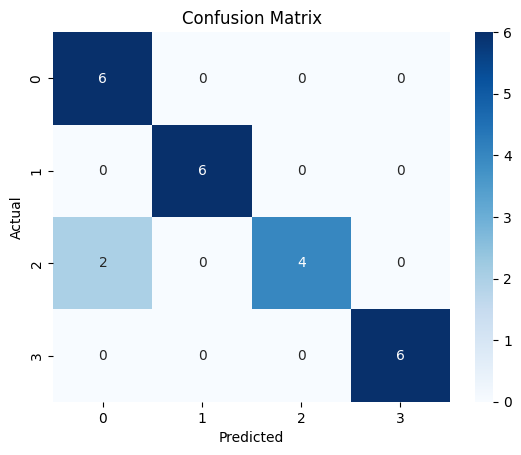

In [157]:
least_squares_accuracy = accuracy_score(Y_1_validation, Y_least_squares_pred)
print(f"Accuracy: {least_squares_accuracy* 100:.2f}")

# plot confusion matrix using heatmap from seaborn
# confusion_matrix = pd.crosstab(Y_1_validation, Y_least_squares_pred, rownames=['Actual'], colnames=['Predicted'])
model_confusion_matrix = confusion_matrix(
    Y_1_validation, Y_least_squares_pred, labels=np.arange(len(selected_frequencies))
)
sns.heatmap(model_confusion_matrix, annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Other methods

Here we are going to compare three different methods: LDA, SVM and the Linear Classifier

### LDA

In [158]:
# Treinar o modelo LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_training, Y_1_training)  # ou Y_2_training, dependendo da variável alvo

# Fazer previsões para os dados de validação
Y_lda_pred = lda.predict(X_validation)

# Calcular a acurácia
lda_accuracy = accuracy_score(Y_1_validation, Y_lda_pred)  # ou Y_2_validation
print(f"Accuracy: {lda_accuracy * 100:.2f}%")

Accuracy: 91.67%


### SVM

In [159]:
# Treinar o modelo SVM
svm = SVC(kernel='linear')  # Você pode ajustar o kernel conforme necessário
svm.fit(X_training, Y_1_training)  # ou Y_2_training

# Fazer previsões para os dados de validação
Y_svm_pred = svm.predict(X_validation)

# Calcular a acurácia
svm_accuracy = accuracy_score(Y_1_validation, Y_svm_pred)  # ou Y_2_validation
print(f"Accuracy: {svm_accuracy * 100:.2f}%")

Accuracy: 91.67%


## Comparison between Least Squares and other methods

Classifying 8 frequencies:
   Least_Squares        LDA        SVM
0      91.666667  91.666667  91.666667


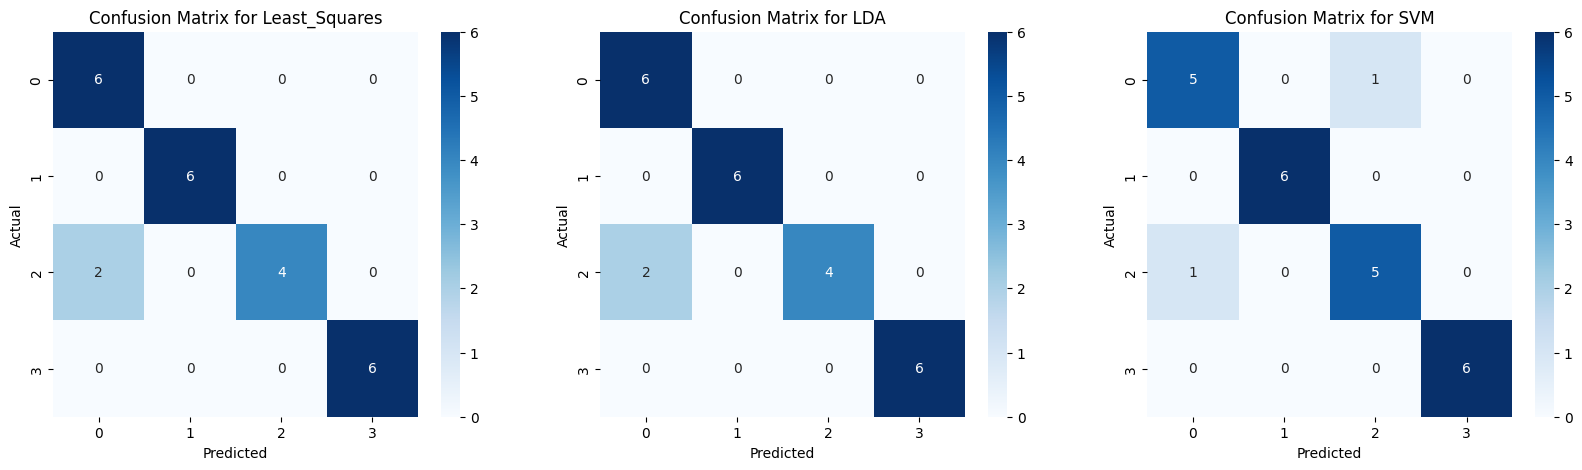

In [160]:
# plot a table with the accuracies of the three classifiers
accuracies = pd.DataFrame(
    {
        "Least_Squares": [least_squares_accuracy * 100],
        "LDA": [lda_accuracy * 100],
        "SVM": [svm_accuracy * 100],
    }
)

print(f"Classifying {number_of_frequencies} frequencies:")
print(accuracies)

# plot confusion matrix using heatmap from seaborn for the three classifiers in three subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

methods = ["Least_Squares", "LDA", "SVM"]
for i, method in enumerate(methods):
    model_confusion_matrix = confusion_matrix(
        Y_1_validation,
        locals()[f"Y_{method.lower()}_pred"],
    )
    sns.heatmap(model_confusion_matrix, annot=True, cmap="Blues", ax=axes[i])
    axes[i].set_title(f"Confusion Matrix for {method}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")